<a href="https://colab.research.google.com/github/rrizwan98/Lungs-Cancer-Dedection/blob/main/cancer_deduction_x_ray_1_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"razarizwanahmed","key":"4006609bc8c19651c7112d296d9f6ba4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/MyDrive/lungs X_Ray.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

In [ ]:
train_dir = '/content/chest_xray/chest_xray/train'
test_dir = '/content/chest_xray/chest_xray/test'
val_dir = '/content/chest_xray/chest_xray/val'

In [ ]:
pneumonia_train_images = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_dir+"/NORMAL/*.jpeg")

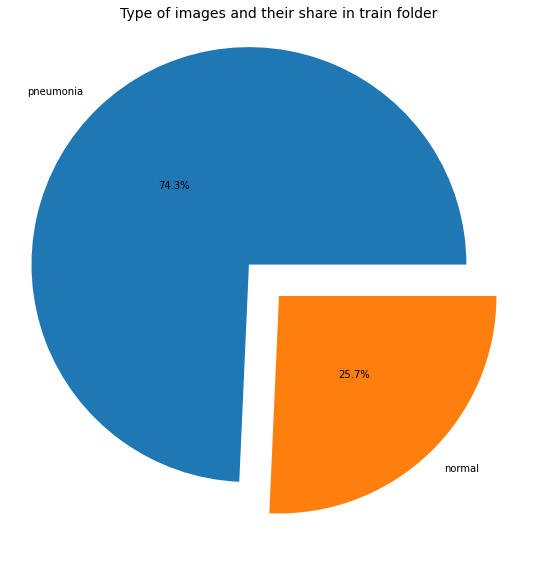

In [ ]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

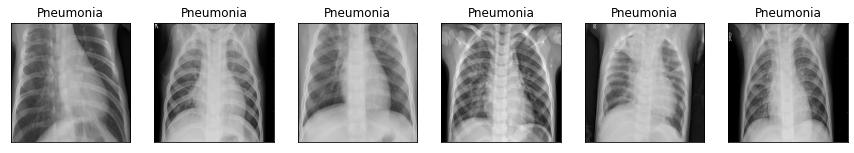

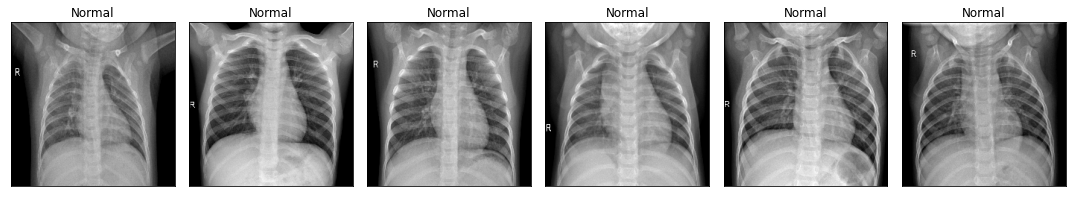

In [ ]:
# e see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

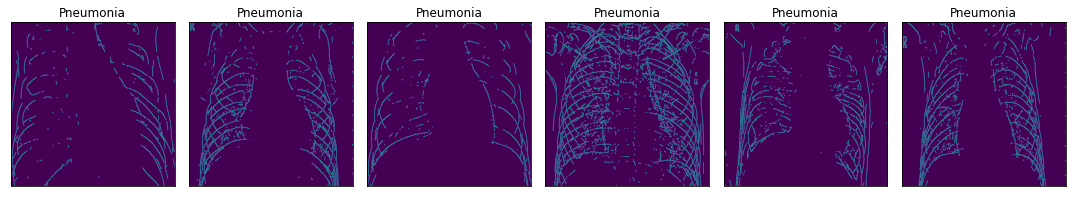

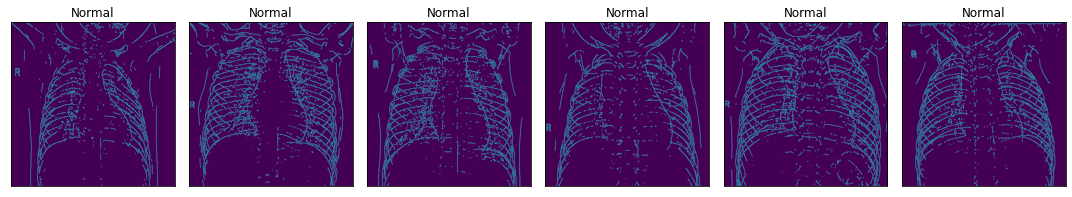

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'binary', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(val_dir,shuffle=False, batch_size=20, class_mode = 'binary', target_size=(220, 220))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


AttributeError: ignored

In [ ]:
input_shape = (220, 220, 3)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
base_model.summary()
    
    


94683136/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
________________________

In [ ]:
from keras import models, regularizers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [ ]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

# callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = len(train_generator), epochs=20,validation_steps=len(validation_generator))


Epoch 1/20
261/261 [==============================] - 157s 476ms/step - loss: 0.2161 - accuracy: 0.9128 - val_loss: 0.3293 - val_accuracy: 0.8638
Epoch 2/20
261/261 [==============================] - 114s 436ms/step - loss: 0.1714 - accuracy: 0.9321 - val_loss: 0.2532 - val_accuracy: 0.9006
Epoch 3/20
261/261 [==============================] - 113s 432ms/step - loss: 0.1461 - accuracy: 0.9431 - val_loss: 0.2328 - val_accuracy: 0.9103
Epoch 4/20
261/261 [==============================] - 112s 429ms/step - loss: 0.1358 - accuracy: 0.9457 - val_loss: 0.2664 - val_accuracy: 0.9006
Epoch 5/20
261/261 [==============================] - 113s 432ms/step - loss: 0.1326 - accuracy: 0.9467 - val_loss: 0.2399 - val_accuracy: 0.9087
Epoch 6/20
261/261 [==============================] - 112s 428ms/step - loss: 0.1295 - accuracy: 0.9480 - val_loss: 0.3658 - val_accuracy: 0.8558
Epoch 7/20
261/261 [==============================] - 113s 431ms/step - loss: 0.1277 - accuracy: 0.9482 - val_loss: 0.2695 -

In [ ]:
model.save("model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

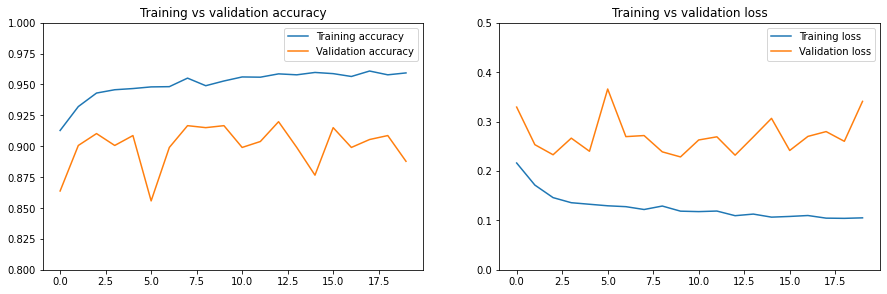

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model.predict(test_generator)
pred

array([[0.8016533 ],
       [0.1697667 ],
       [0.18203898],
       [0.8446661 ],
       [0.20261621],
       [0.95016515],
       [0.01626198],
       [0.01836814],
       [0.99999964],
       [0.9999325 ],
       [0.99007857],
       [0.90620226],
       [0.9322961 ],
       [0.99998605],
       [0.99984837],
       [0.99948645]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred


[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

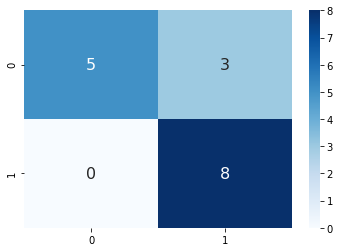

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



## **Fine-tune ResNet50V2**

In [ ]:
for layer in base_model.layers[:]:
   layer.trainable = False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
# Make last block of the conv_base trainable:

for layer in base_model.layers[:177]:
   layer.trainable = False
for layer in base_model.layers[177:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=["accuracy"])
model.summary()
# callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
F_history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch = len(train_generator),
                    epochs=20,
                    validation_steps=len(validation_generator))


Epoch 1/20
261/261 [==============================] - 156s 462ms/step - loss: 1.6277 - accuracy: 0.7339 - val_loss: 1.5936 - val_accuracy: 0.6587
Epoch 2/20
261/261 [==============================] - 109s 417ms/step - loss: 1.4306 - accuracy: 0.8330 - val_loss: 1.4391 - val_accuracy: 0.8349
Epoch 3/20
261/261 [==============================] - 109s 417ms/step - loss: 1.3254 - accuracy: 0.8854 - val_loss: 1.3622 - val_accuracy: 0.8686
Epoch 4/20
261/261 [==============================] - 109s 417ms/step - loss: 1.2749 - accuracy: 0.9015 - val_loss: 1.3139 - val_accuracy: 0.8862
Epoch 5/20
261/261 [==============================] - 107s 411ms/step - loss: 1.2107 - accuracy: 0.9189 - val_loss: 1.2638 - val_accuracy: 0.9006
Epoch 6/20
261/261 [==============================] - 108s 412ms/step - loss: 1.1644 - accuracy: 0.9339 - val_loss: 1.2368 - val_accuracy: 0.9054
Epoch 7/20
261/261 [==============================] - 107s 410ms/step - loss: 1.1544 - accuracy: 0.9312 - val_loss: 1.2345 -

In [ ]:
model.save("model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<Figure size 432x288 with 0 Axes>

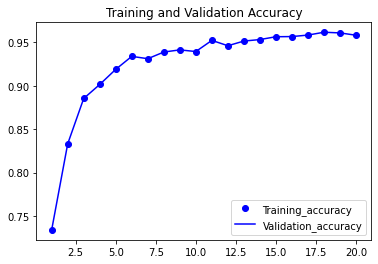

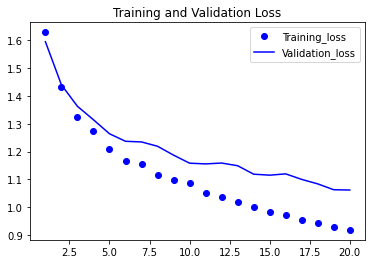

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc=F_history.history['accuracy']
val_acc=F_history.history['val_accuracy']
loss=F_history.history['loss']
val_loss=F_history.history['val_loss']

epochs=range(1,len(acc) +1)

plt.plot(epochs , acc ,'bo' ,label='Training_accuracy')
plt.plot(epochs , acc ,'b' ,label='Validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs ,loss ,'bo' ,label='Training_loss')
plt.plot(epochs , val_loss ,'b',label='Validation_loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.figure()

### **Data Augmentation**

In [ ]:
pred = model.predict(test_generator)
pred

array([[0.6324101 ],
       [0.02459417],
       [0.09855709],
       [0.04016409],
       [0.19249085],
       [0.89990795],
       [0.0052907 ],
       [0.0083925 ],
       [0.9999963 ],
       [0.99986076],
       [0.8272026 ],
       [0.80717164],
       [0.9678649 ],
       [0.9995741 ],
       [0.9994923 ],
       [0.9986333 ]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred


[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

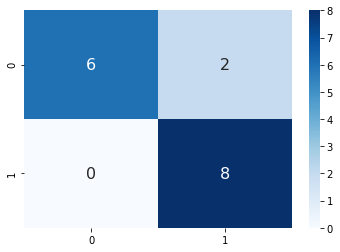

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

